In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## EDA

In [4]:
df = pd.read_csv('train.csv')

In [5]:
##function to clean text
def text_clean(df, text_col):
    import re
    df[text_col] = df[text_col].apply(lambda x: re.sub(',', '', x)) #replace commas without space to prevent additional spaces in sentences
    df[text_col] = df[text_col].apply(lambda x: re.sub("'", '', x)) #replace ' next to get words like dont, wont, etc.
    df[text_col] = df[text_col].apply(lambda x: re.sub('[^ a-zA-Z0-9!]', ' ', x).lower()) #replace weird char without ! (!+  seems to appear quite abit in toxic comments) + lower case
    df[text_col] = df[text_col].apply(lambda x: " ".join(x.split())) #remove additional spaces
text_clean(df, 'comment_text')

In [6]:
#train-test split
from sklearn.model_selection import train_test_split
labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
X = df['comment_text']
y = df[labels]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train = pd.concat([X_train,y_train], axis=1)
test = pd.concat([X_test,y_test], axis=1)

In [7]:
#step 1 model
train['neg'] = train[labels].sum(axis=1)
train['neg'] = train['neg'].map(lambda x: 1 if x > 0 else 0)
train1_X = train['comment_text']
train1_y = train['neg']

test['neg'] = test[labels].sum(axis=1)
test['neg'] = test['neg'].map(lambda x: 1 if x > 0 else 0)
test1_X = test['comment_text']
test1_y = test['neg']

print (train1_X.shape, train1_y.shape)
print (test1_X.shape, test1_y.shape)

(127656,) (127656,)
(31915,) (31915,)


In [8]:
#step 2 model
train2 = train[train['neg']==1]
train2_X = train2['comment_text']
train2_y = train2[labels]

test2 = test[test['neg']==1]
test2_X = test2['comment_text']
test2_y = test2[labels]

print (train2_X.shape, train2_y.shape)
print (test2_X.shape, test2_y.shape)

(12981,) (12981, 6)
(3244,) (3244, 6)


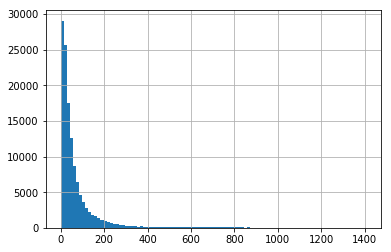

In [9]:
train['count_word']=train["comment_text"].apply(lambda x: len(str(x).split()))
train['count_word'].hist(bins=100)

In [10]:
train['count_word'].quantile(q=0.9) #about 90% of the words have less than 154 words present
#choose 150 as maxlen

154.0

## Model Setting

### Model 1 setting

In [11]:
#https://www.kaggle.com/jhoward/improved-lstm-baseline-glove-dropout

import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, GRU, Embedding, Dropout, Activation, SpatialDropout1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
EMBEDDING_FILE= 'glove.6B/glove.6B.100d.txt'

In [13]:
embed_size = 100 # how big is each word vector according to glove embeddings used
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 150 # max number of words in a comment to use

In [14]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train['comment_text'])) #fit tokenizer on train set only
list_tokenized_train = tokenizer.texts_to_sequences(train['comment_text']) #tokenize to seq transform for train set
list_tokenized_test = tokenizer.texts_to_sequences(test['comment_text']) #tokenize to seq transform for test set
X1_t = pad_sequences(list_tokenized_train, maxlen=maxlen) #pad to max sentence len of 150 sequences to form matrix
X1_te = pad_sequences(list_tokenized_test, maxlen=maxlen) #pad to max sentence len of 150 sequences to form matrix

In [15]:
testing = ['i am a boy']
testing2 = ['i', 'am', 'a', 'boy']
print (testing2)
print (tokenizer.texts_to_sequences(testing))
print (pad_sequences(tokenizer.texts_to_sequences(testing), 10))

# [[0 0 0 0 0 0 6 73 5 1642]]

['i', 'am', 'a', 'boy']
[[6, 73, 5, 1642]]
[[   0    0    0    0    0    0    6   73    5 1642]]


In [16]:
import pickle
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
y1_t = train1_y.values
y1_te = test1_y.values

In [18]:
print ('X1_t shape:', X1_t.shape)
print ('X1_te shape:', X1_te.shape)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X1_t shape: (127656, 150)
X1_te shape: (31915, 150)
Found 166275 unique tokens.


### Model 2 setting

In [19]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train['comment_text'])) #fit tokenizer on train set only
list_tokenized_train = tokenizer.texts_to_sequences(train2['comment_text']) #tokenize to seq transform for train set
list_tokenized_test = tokenizer.texts_to_sequences(test2['comment_text']) #tokenize to seq transform for test set
X2_t = pad_sequences(list_tokenized_train, maxlen=maxlen) #pad to max sentence len of 150 sequences to form matrix
X2_te = pad_sequences(list_tokenized_test, maxlen=maxlen) #pad to max sentence len of 150 sequences to form matrix

In [20]:
y2_t = train2_y.values
y2_te = test2_y.values

In [21]:
print ('X2_t shape:', X2_t.shape)
print ('X2_te shape:', X2_te.shape)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X2_t shape: (12981, 150)
X2_te shape: (3244, 150)
Found 166275 unique tokens.


### Embedding setting

In [22]:
#Read the glove word vectors (space delimited strings) into a dictionary from word->vector.
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding="utf8"))

In [23]:
len(embeddings_index)

400000

Use these glove vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init.

In [24]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.004451992, 0.4081574)

In [25]:
word_index = tokenizer.word_index #get word dictionary from tokenized fit
nb_words = min(max_features, len(word_index)) #no. of words to embed
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size)) #randomize embedding matrix with shape (nb_words, embed_size)
for word, i in word_index.items():
    if i >= nb_words: continue #if word index item is larger (lower occurring words)than words required to embed (top 20,000 words), continue
    embedding_vector = embeddings_index.get(word) #otherwise get the vector from the glove embedding_index
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector #if word vectors not present, leave as the random intialized vectors

## Model Training

### Model 1 training

In [23]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 100)          2000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 100)          60400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total para

In [42]:
no_epochs = 5 # number of epochs

for i in range(1,no_epochs):
    model.fit(X1_t, y1_t, #model.fit for saved model, md.fit for new model (for changes in architecture)
                 batch_size=32,
                 shuffle=True,
                 epochs=1,
                 validation_split=0.05)
    model.save('toxic_md1_preemb'+str(i)+'.h5') 

Train on 121273 samples, validate on 6383 samples
Epoch 1/1
121273/121273 [==============================] - 2233s 18ms/step - loss: 0.1165 - acc: 0.9569 - val_loss: 0.0948 - val_acc: 0.9671
Train on 121273 samples, validate on 6383 samples
Epoch 1/1
121273/121273 [==============================] - 2599s 21ms/step - loss: 0.0836 - acc: 0.9687 - val_loss: 0.0879 - val_acc: 0.9680
Train on 121273 samples, validate on 6383 samples
Epoch 1/1
121273/121273 [==============================] - 2255s 19ms/step - loss: 0.0678 - acc: 0.9738 - val_loss: 0.0933 - val_acc: 0.9668
Train on 121273 samples, validate on 6383 samples
Epoch 1/1
121273/121273 [==============================] - 2267s 19ms/step - loss: 0.0531 - acc: 0.9795 - val_loss: 0.1096 - val_acc: 0.9674


### Model 2 training

In [24]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 100)          2000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 100)          60400     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 306       
Total para

In [44]:
no_epochs = 5 # number of epochs

for i in range(1,no_epochs):
    model.fit(X2_t, y2_t, #model.fit for saved model, md.fit for new model (for changes in architecture)
                 batch_size=32,
                 shuffle=True,
                 epochs=1,
                 validation_split=0.05)
    model.save('toxic_md2_preemb'+str(i)+'.h5')

Train on 12331 samples, validate on 650 samples
Epoch 1/1
12331/12331 [==============================] - 255s 21ms/step - loss: 0.3489 - acc: 0.8464 - val_loss: 0.3149 - val_acc: 0.8636
Train on 12331 samples, validate on 650 samples
Epoch 1/1
12331/12331 [==============================] - 233s 19ms/step - loss: 0.2795 - acc: 0.8837 - val_loss: 0.2896 - val_acc: 0.8751
Train on 12331 samples, validate on 650 samples
Epoch 1/1
12331/12331 [==============================] - 227s 18ms/step - loss: 0.2538 - acc: 0.8940 - val_loss: 0.2887 - val_acc: 0.8754
Train on 12331 samples, validate on 650 samples
Epoch 1/1
12331/12331 [==============================] - 247s 20ms/step - loss: 0.2365 - acc: 0.9013 - val_loss: 0.2826 - val_acc: 0.8751


## Model performance

In [25]:
#write function to measure model performance
def model_performance(model, X_test, y_test):
    
    Y_pp = pd.DataFrame(model.predict(X_test))
    
    #roc, auc for model for common performance measurement
    from sklearn.metrics import roc_curve, auc
    # For class 1, find the area under the curve.
    fpr, tpr, _ = roc_curve(y_test, Y_pp)
    roc_auc = auc(fpr, tpr)
    # Plot of a ROC curve.
    plt.figure(figsize=[4,4])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for 1', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()
    print ('auc:',roc_auc)
    
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn import metrics
    
    #predict
    class_pred = Y_pp[0].apply(lambda x: 1 if x > 0.5 else 0)
    #confusion matrix and f1-score
    conmat = np.array(confusion_matrix(y_test, class_pred))
    confusion = pd.DataFrame(conmat, index=["class_0", "class_1"], 
                             columns=["predicted_0","predicted_1"])
    f1_score = metrics.f1_score(y_test, class_pred, average='weighted')
    precision_score = metrics.precision_score(y_test, class_pred, average='weighted')
    print ('')
    print ('Confusion Table:')
    print (confusion)
    print ('')
    print ('Classification Report:')
    print (classification_report(y_test, class_pred))
    print ('f1:',f1_score)
    print ('precision:',precision_score)
    return roc_auc, f1_score, precision_score

### Model 1 performance

In [26]:
from keras.models import load_model
model1 = load_model('toxic_md1_preemb4.h5')

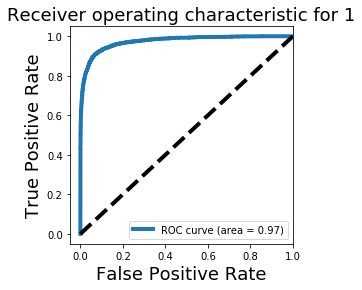

auc: 0.9735584750092906

Confusion Table:
         predicted_0  predicted_1
class_0        28307          364
class_1          820         2424

Classification Report:
             precision    recall  f1-score   support

          0       0.97      0.99      0.98     28671
          1       0.87      0.75      0.80      3244

avg / total       0.96      0.96      0.96     31915

f1: 0.9616455364496309
precision: 0.9614382711182796


(0.9735584750092906, 0.9616455364496309, 0.9614382711182796)

In [27]:
model_performance(model1, X1_te, y1_te)

### Model 2 performance

In [28]:
from keras.models import load_model
model2 = load_model('toxic_md2_preemb4.h5')

In [29]:
Y_pp = pd.DataFrame(model2.predict(X2_te))

toxic


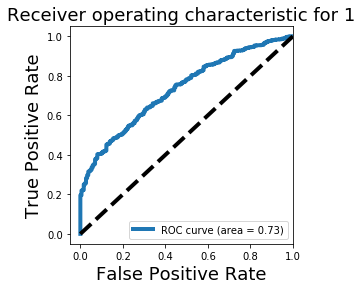

auc: 0.7309669850729643

Confusion Table:
         predicted_0  predicted_1
class_0            0          188
class_1            0         3056

Classification Report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       188
          1       0.94      1.00      0.97      3056

avg / total       0.89      0.94      0.91      3244

f1: 0.9139349813085941
precision: 0.8874522783976793
severe_toxic


C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


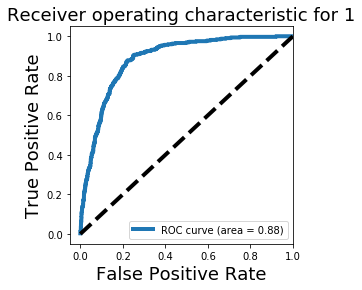

auc: 0.8842550701653978

Confusion Table:
         predicted_0  predicted_1
class_0         2782          141
class_1          205          116

Classification Report:
             precision    recall  f1-score   support

          0       0.93      0.95      0.94      2923
          1       0.45      0.36      0.40       321

avg / total       0.88      0.89      0.89      3244

f1: 0.8880140954111022
precision: 0.8838716172800273
obscene


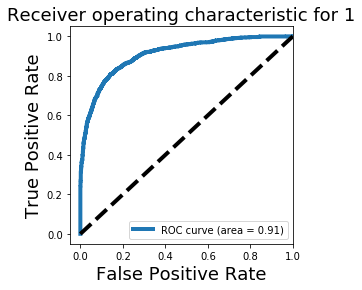

auc: 0.9093822636033766

Confusion Table:
         predicted_0  predicted_1
class_0         1285          244
class_1          310         1405

Classification Report:
             precision    recall  f1-score   support

          0       0.81      0.84      0.82      1529
          1       0.85      0.82      0.84      1715

avg / total       0.83      0.83      0.83      3244

f1: 0.8293518837889554
precision: 0.8301669751751748
threat


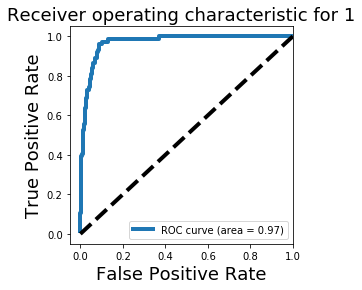

auc: 0.9700741751214937

Confusion Table:
         predicted_0  predicted_1
class_0         3147           23
class_1           45           29

Classification Report:
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      3170
          1       0.56      0.39      0.46        74

avg / total       0.98      0.98      0.98      3244

f1: 0.9772444713790738
precision: 0.9761342112038135
insult


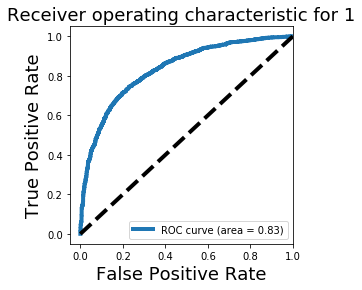

auc: 0.8322370971788264

Confusion Table:
         predicted_0  predicted_1
class_0         1282          348
class_1          449         1165

Classification Report:
             precision    recall  f1-score   support

          0       0.74      0.79      0.76      1630
          1       0.77      0.72      0.75      1614

avg / total       0.76      0.75      0.75      3244

f1: 0.7540394185648069
precision: 0.7552304204098887
identity_hate


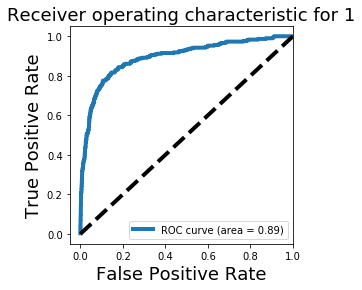

auc: 0.8932681886313848

Confusion Table:
         predicted_0  predicted_1
class_0         2871           79
class_1          155          139

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.97      0.96      2950
          1       0.64      0.47      0.54       294

avg / total       0.92      0.93      0.92      3244

f1: 0.9229718755570989
precision: 0.9205769554728824


In [30]:
from sklearn.metrics import roc_curve, auc
# For class 1, find the area under the curve.
for i in range(Y_pp.shape[1]):
    print (labels[i])
    fpr, tpr, _ = roc_curve(y2_te[:,i], Y_pp.iloc[:,i])
    roc_auc = auc(fpr, tpr)
    # Plot of a ROC curve.
    plt.figure(figsize=[4,4])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for 1', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()
    print ('auc:',roc_auc)
    
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn import metrics
    
    #predict
    class_pred = Y_pp.iloc[:,i].apply(lambda x: 1 if x > 0.5 else 0)
    #confusion matrix and f1-score
    conmat = np.array(confusion_matrix(y2_te[:,i], class_pred))
    confusion = pd.DataFrame(conmat, index=["class_0", "class_1"], 
                             columns=["predicted_0","predicted_1"])
    f1_score = metrics.f1_score(y2_te[:,i], class_pred, average='weighted')
    precision_score = metrics.precision_score(y2_te[:,i], class_pred, average='weighted')
    print ('')
    print ('Confusion Table:')
    print (confusion)
    print ('')
    print ('Classification Report:')
    print (classification_report(y2_te[:,i], class_pred))
    print ('f1:',f1_score)
    print ('precision:',precision_score)
#     return roc_auc, f1_score, precision_score

## Productionising

In [2]:
#load models
from keras.models import load_model
import pickle
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import re
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
model1 = load_model('toxic_md1_preemb4.h5')
model2 = load_model('toxic_md2_preemb4.h5')

C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#get cleaning function
def text_clean(df, text_col):
    df[text_col] = df[text_col].apply(lambda x: re.sub(',', '', x)) #replace commas without space to prevent additional spaces in sentences
    df[text_col] = df[text_col].apply(lambda x: re.sub("'", '', x)) #replace ' next to get words like dont, wont, etc.
    df[text_col] = df[text_col].apply(lambda x: re.sub('[^ a-zA-Z0-9!]', ' ', x).lower()) #replace weird char without ! (!+  seems to appear quite abit in toxic comments) + lower case
    df[text_col] = df[text_col].apply(lambda x: " ".join(x.split())) #remove additional spaces

In [132]:
input1 = input()
input_df = pd.DataFrame([input1], columns=['comment_text'])
text_clean(input_df, 'comment_text')
input_seq = tokenizer.texts_to_sequences(input_df['comment_text'])
pad_seq = pad_sequences(input_seq, maxlen=150)
y_pred1 = model1.predict(pad_seq)
print ('negative {}%'.format(round(y_pred1[0][0]*100,2)))
labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
if y_pred1 > 0.5:
    y_pred2 = model2.predict(pad_seq)
    for i in range(y_pred2.shape[1]):
        print ("{} {}%".format(labels[i], round(y_pred2[0][i]*100,2)))

this is fucking awesome
negative 99.96%
toxic 97.81%
severe_toxic 9.03%
obscene 98.07%
threat 0.13%
insult 29.67%
identity_hate 0.65%


In [1]:
input2 = input()

how are you


## Final 2 step combination score for comparison

In [1]:
y_pred_neg = model1.predict(X1_te)

NameError: name 'model1' is not defined

In [153]:
#get the vectorized test set with labels
combine_test = pd.concat([pd.DataFrame(X1_te), test.reset_index(drop=True)[labels]], axis=1)
#concat the vectorized test set & labels with predicted negativity
combine_test = pd.concat([combine_test, pd.DataFrame(y_pred_neg, columns=['pred_neg'])], axis=1)

In [163]:
#get neg dataset out for those predicted neg > 0.5
neg_test = combine_test[combine_test['pred_neg']>0.5]

In [168]:
#drop irrelevant columns (label and neg pred) for model2
step2_te = neg_test.drop(labels, axis=1)
step2_te = step2_te.drop(['pred_neg'],axis=1)

In [169]:
#predict type of toxicity with model2
predictions = model2.predict(step2_te)

In [170]:
#classify toxicity predictions by model2
labels_pred = []
for label in labels:
    labels_pred.append(label+'_pred')
predictions_df = pd.DataFrame(predictions, columns=labels_pred) #dataframe prediction probabilities
predictions_df = (predictions_df>0.5)*1 #get predicted classes

In [189]:
#set prediction_df with neg dataset neg_test index
index = neg_test.index
predictions_df = predictions_df.set_index(index)
#concat predictions and actual labels
pred_label_df = pd.concat([combine_test[labels],predictions_df], axis=1)
pred_label_df = pred_label_df.fillna(0) #fill na values (predicted not negative) with 0

In [191]:
#get confusion table and scores
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

f1_ls = []
precision_ls = []

for i, label in enumerate(labels):
    print (label)
    conmat = np.array(confusion_matrix(pred_label_df[label], pred_label_df[labels_pred[i]]))
    confusion = pd.DataFrame(conmat, index=["class_0", "class_1"], 
                             columns=["predicted_0","predicted_1"])    

    f1_score = metrics.f1_score(pred_label_df[label], pred_label_df[labels_pred[i]], average='weighted')
    precision_score = metrics.precision_score(pred_label_df[label], pred_label_df[labels_pred[i]], average='weighted')
    f1_ls.append(f1_score)
    precision_ls.append(precision_score)
    print ('')
    print ('Confusion Table:')
    print (confusion)
    print ('')
    print ('Classification Report:')
    print (classification_report(pred_label_df[label], pred_label_df[labels_pred[i]]))
    print ('f1:',f1_score)
    print ('precision:',precision_score)
scores = [f1_ls, precision_ls]
metrics = pd.DataFrame(scores, columns=labels, index=(['f1','presc']))
metrics

toxic

Confusion Table:
         predicted_0  predicted_1
class_0        28399          460
class_1          728         2328

Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.98      0.98     28859
          1       0.84      0.76      0.80      3056

avg / total       0.96      0.96      0.96     31915

f1: 0.9620086199567555
precision: 0.9616005111181342
severe_toxic

Confusion Table:
         predicted_0  predicted_1
class_0        31453          141
class_1          205          116

Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99     31594
          1       0.45      0.36      0.40       321

avg / total       0.99      0.99      0.99     31915

f1: 0.9885639773305903
precision: 0.9880714895423869
obscene

Confusion Table:
         predicted_0  predicted_1
class_0        29957          243
class_1          343         1372

Classification Report:
     

,toxic,severe_toxic,obscene,threat,insult,identity_hate
f1,0.962009,0.988564,0.981378,0.997684,0.973916,0.992036
presc,0.961601,0.988071,0.981203,0.997565,0.973574,0.991713


<b> Similar to the basic 2 step model, though the LSTM 2 step model performs slightly worse off than single step model in terms of precision for toxic types, <br>
f1 scores are higher and recall rates for the different toxicity are all significantly higher.

In [73]:
#alternative model
# inp = Input(shape=(maxlen, ))
# x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
# x = SpatialDropout1D(0.2)(x)
# x = Bidirectional(GRU(80, return_sequences=True))(x)
# avg_pool = GlobalAveragePooling1D()(x)
# max_pool = GlobalMaxPooling1D()(x)
# conc = concatenate([avg_pool, max_pool])
# outp = Dense(6, activation="sigmoid")(conc)

# model = Model(inputs=inp, outputs=outp)
# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 150, 100)     2000000     input_10[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 150, 100)     0           embedding_10[0][0]               
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 150, 160)     86880       spatial_dropout1d_3[0][0]        
__________________________________________________________________________________________________
global_ave

In [ ]:
model.fit(X_t, y_t, batch_size=32, epochs=5, validation_split=0.1);

In [64]:
combine_test

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,neg_pred
0,0,0,0,0,0,0,0,0,0,0,...,2179,3867,3288,46,7,458,156,5,10722,1
1,0,0,0,0,0,0,0,0,0,0,...,17,30,604,45,260,36,71,126,7,0
2,0,0,0,0,0,0,0,0,0,0,...,49,40,6,33,782,1840,301,35,298,0
3,0,0,0,0,0,0,0,0,0,0,...,455,5535,488,4,1,457,245,186,1057,0
4,0,0,0,0,0,0,0,0,0,0,...,22,443,28,8,14,831,17,5,442,0
5,0,0,0,0,0,0,0,0,0,0,...,3396,3,4782,15,1,8504,8,715,789,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,449,1127,7863,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,8017,1693,3562,2239,988,35,0
8,0,0,0,0,0,0,0,0,0,0,...,16,1618,2,51,2145,1,13146,4,2138,0
9,0,0,0,0,0,0,0,0,0,0,...,2824,10,505,2,97,191,7,252,36,0
